## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"Hey can you see if i can get my car checked sure what city im in manhattan ok sir i found a shop what is the purpose of the visit? my car has been pulling to the left when braking thats very dangerous would you like an urgent appointment yes thats what I need ok and what is the make and model mazda miata 1999 ok let me relay that information ok they say you can drop the car off tomorrow morning no, I need it checked today ok let me check ok they said they can squeeze you in for a appointment in 2 hours. yes il take that one ok sounds good thank you for the help of course and just to reassure, your car is moving off center when braking and it is a mazda miata 1999 yes, correct ok, youre all set.",auto-repair-appt-1,0
126,"Hello, I need to make a car appointment please. No problem! What is the issue? Well my brakes aren't working well and I need them looked at. Okay no problem. When do you need it? I need the appointment quickly. Can we do it today? One moment while I check what is available. Okay thank you. I have found 3 places available but none are for today unfortunately. Okay can I do it in the morning? Yes there is one available spot tomorrow morning at 9 AM. Okay that is great. Where is it? It is at the Advanced Auto Parts down the road from you. Great! That is only a few minutes away. How much will it cost? A brake inspection is going to be $59.99. Alright thank you I would like to confirm the appointment. I have you set up for an appointment at your closest Advanced Auto Parts at 9 AM tomorrow. Great that is perfect for me. Is there anything else I can do for you? No that is great! Thank you! You are welcome and have a great day!",auto-repair-appt-1,0
555,How much is an adult ticket Where is the theater located $13 Chino hills How much is a child's ticket $10 When is the next showing of how men think 5pm can I have 2 adult tickets please Sure that will be $26 is there a later showing tomorrow Yes 3 pm Okay I'll just take the two adult tickets For today? Yes for today Okay that will be $26 Ok Odd this in cash form No Which form is it? Debit card Okay one moment Hello Yes Would it be easier if I paid in cash No it's okay Okay Okay there's your tickets Okay thank you Thank you enjoy your movie,movie-tickets-1,1
1260,"I am in the mood for some good steaks for dinner. A nice restaurant with good atmosphere. Would you like reservations for this evening or tomorrow perhaps? For this Saturday evening. I'd like the downtown Chandlers at 7:30. A table for four. Can you see if their outdoor dining is open yet? The Downtown Chandlers does not have outdoor seating. It also does not have any reservations available at 7:30. What about 8:00? On Saturday, that Chandler's location is booked through 8:45. Okay, does the Eagle location of Chanlers have outdoor seating? No, it does not have outdoor seating. What about Rafael's? Is it available? Rafaels by thby the river has reservations available at 7:30 on Saturday evening. Great. Make a reservation. Would you like the reservation for the Patio then? Yes. I'd like a table on the Patio overlooking the river view. And that reservation is for a table for 4? Yes, there will be four of us. Let them know we're celebrating a birthday. Would you like to pre-order a special birthday desert? No, we'll decide when we get there. Certainly. A reservation for 4 at Rafaels by the river at 7:30 this Saturday. A table on the patio overlooking the river and celebrating a birthday. Perfect. Your reservation has been made under the name Anderson. Thank you.",restaurant-table-2,2
902,"Hey Rebecca, it looks like this meeting is going to last until dinner time. Could you please order about 3 pizzas from Capri's? Yes ma'am. Do you want this to be delivered or do you want me to send someone to pick it up. Actually, I want it to be picked up so that we can eat it while it's hot. That will be fine. Do you want me to order the usual combination or a previous order? No, 

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"Hey can you see if i can get my car checked sure what city im in manhattan ok sir i found a shop what is the purpose of the visit? my car has been pulling to the left when braking thats very dangerous would you like an urgent appointment yes thats what I need ok and what is the make and model mazda miata 1999 ok let me relay that information ok they say you can drop the car off tomorrow morning no, I need it checked today ok let me check ok they said they can squeeze you in for a appointment in 2 hours. yes il take that one ok sounds good thank you for the help of course and just to reassure, your car is moving off center when braking and it is a mazda miata 1999 yes, correct ok, youre all set.",auto-repair-appt-1,0,hey see get car checked sure city im manhattan ok sir found shop purpose visit car pulling left braking thats dangerous would like urgent appointment yes thats need ok make model mazda miata ok let relay information ok say drop car tomorrow morning need checked today ok let check ok said squeeze appointment hours yes il take one ok sounds good thank help course reassure car moving center braking mazda miata yes correct ok youre set
126,"Hello, I need to make a car appointment please. No problem! What is the issue? Well my brakes aren't working well and I need them looked at. Okay no problem. When do you need it? I need the appointment quickly. Can we do it today? One moment while I check what is available. Okay thank you. I have found 3 places available but none are for today unfortunately. Okay can I do it in the morning? Yes there is one available spot tomorrow morning at 9 AM. Okay that is great. Where is it? It is at the Advanced Auto Parts down the road from you. Great! That is only a few minutes away. How much will it cost? A brake inspection is going to be $59.99. Alright thank you I would like to confirm the appointment. I have you set up for an appointment at your closest Advanced Auto Parts at 9 AM tomorrow. Great that is perfect for me. Is there anything else I can do for you? No that is great! Thank you! You are welcome and have a great day!",auto-repair-appt-1,0,hello need make car appointment please problem issue well brakes arent working well need looked okay problem need need appointment quickly today one moment check available okay thank found places available none today unfortunately okay morning yes one available spot tomorrow morning okay great advanced auto parts road great minutes away much cost brake inspection going alright thank would like confirm appointment set appointment closest advanced auto parts tomorrow great perfect anything else great thank welcome great day
555,How much is an adult ticket Where is the theater located $13 Chino hills How much is a child's ticket $10 When is the next showing of how men think 5pm can I have 2 adult tickets please Sure that will be $26 is there a later showing tomorrow Yes 3 pm Okay I'll just take the two adult tickets For today? Yes for today Okay that will be $26 Ok Odd this in cash form No Which form is it? Debit card Okay one moment Hello Yes Would it be easier if I paid in cash No it's okay Okay Okay there's your tickets Okay thank you Thank you enjoy your movie,movie-tickets-1,1,much adult ticket theater located chino hills much childs ticket next showing men think pm adult tickets please sure later showing tomorrow yes pm okay ill take two adult tickets today yes today okay ok odd cash form form debit card okay one moment hello yes would easier paid cash okay okay okay theres tickets okay thank thank enjoy movie


In [12]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['hello need make car appointment please problem issue well brakes arent working well need looked okay problem need need appointment quickly today one moment check available okay thank found places available none today unfortunately okay morning yes one available spot tomorrow morning okay great advanced auto parts road great minutes away much cost brake inspection going alright thank would like confirm appointment set appointment closest advanced auto parts tomorrow great perfect anything else great thank welcome great day',
 'much adult ticket theater located chino hills much childs ticket next showing men think pm adult tickets please sure later showing tomorrow yes pm okay ill take two adult tickets today yes today okay ok odd cash form form debit card okay one moment hello yes would easier paid cash okay okay okay theres tickets okay thank thank enjoy movie',
 'mood good steaks dinner nice restaurant good atmosphere would like reservations evening tomorrow perhaps saturday evening

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 6115
Vocabulary Sample: [('like', 1), ('would', 2), ('ok', 3), ('okay', 4), ('yes', 5), ('want', 6), ('pm', 7), ('order', 8), ('thank', 9), ('time', 10)]


#### Build (context_words, target_word) pair generator

In [14]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [15]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['need', 'make', 'car', 'looked'] -> Target (Y): appointment
Context (X): ['make', 'appointment', 'looked', 'ok'] -> Target (Y): car
Context (X): ['appointment', 'car', 'ok', 'would'] -> Target (Y): looked
Context (X): ['car', 'looked', 'would', 'like'] -> Target (Y): ok
Context (X): ['looked', 'ok', 'like', 'take'] -> Target (Y): would
Context (X): ['ok', 'would', 'take', 'inspection'] -> Target (Y): like
Context (X): ['would', 'like', 'inspection', 'would'] -> Target (Y): take
Context (X): ['like', 'take', 'would', 'like'] -> Target (Y): inspection
Context (X): ['take', 'inspection', 'like', 'take'] -> Target (Y): would
Context (X): ['inspection', 'would', 'take', 'intelligent'] -> Target (Y): like
Context (X): ['would', 'like', 'intelligent', 'auto'] -> Target (Y): take


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [16]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 3, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 6, 5, ..., 0, 0, 0]], dtype=int64)

In [19]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,ok,okay,yes,want,pm,order,thank,time,tickets,please,one,need,...,antiqua,stephen,joking,promoted,ughhh,shocked,avilable,ticfkets,navagation,loading,chakras,fairyland,freed,diner,highchair
0,0,3,3,3,0,1,1,1,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,3,0,0,2,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,2,3,1,5,0,2,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,3,0,1,5,0,1,3,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2,1,0,2,2,2,0,3,0,1,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,5,6,0,4,2,2,0,6,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,3,3,0,1,1,1,0,0,0,0,0,0,2,3,...,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
997,0,1,0,5,0,3,0,0,0,4,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,5,1,1,4,0,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 6115)
(250, 6115)
(250,)


#### Define Model Builder Function

In [21]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

class Result_Metrics:
    def __init__(self, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)


    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()
    precision = metrics.precision_score(labels_test, pred, average='weighted')
    recall = metrics.recall_score(labels_test, pred, average='weighted')
    
    rm = Result_Metrics(pred, cm, report, f1, accuracy, precision, recall)

    return rm

## Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [22]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
rm_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [23]:

def Save_Benchmark(descr, feat_type, b_metrics, reset_rb, reset_rb_all):
    global rows_benchmarks
    global rows_benchmarks_all
    global df_benchmarks
    global df_benchmarks_all
    if (reset_rb):
        rows_benchmarks = []

    if (reset_rb_all):
        rows_benchmarks_all = []
    rows_benchmarks.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    rows_benchmarks_all.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])
    df_benchmarks_all = pd.DataFrame(rows_benchmarks_all, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])


In [24]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Baseline", "BOW", rm_nb_bow, True, True)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.7243102,0.6960000,0.6838492,0.6960000


In [25]:
from sklearn.metrics import confusion_matrix

rm_nb_bow.cm

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0, 11, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 18,  3,  1,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  2, 16,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3, 18,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 23,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  2,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 12,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  6,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 12]],
      dtype=int64)

In [26]:
from sklearn import metrics

print("Label" + rm_nb_bow.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.67      0.32      0.43        19
 coffee-ordering-2       0.56      0.88      0.68        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.75      0.90      0.82        20
   movie-tickets-2       0.70      0.73      0.71        22
   movie-tickets-3       0.86      0.75      0.80        24
  pizza-ordering-1       0.89      0.57      0.70        14
  pizza-ordering-2       0.79      1.00      0.88        23
restaurant-table-1       0.73      0.36      0.48        22
restaurant-table-2       0.38      0.71      0.49        17
restaurant-table-3       0.50      0.38      0.43        16
       uber-lyft-1       0.71      0.33      0.45        15
       uber-lyft-2       0.60      0.92      0.73        13

          accuracy                           0.70       250
         macro avg       0.72    

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Functions

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

class Result_Metrics_selected:
    def __init__(self, x_train_sel, x_test_sel, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.x_train_sel = x_train_sel
        self.x_test_sel = x_test_sel
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def SelectAndScaleFeatures_Chi(num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    #X_norm = MinMaxScaler(feature_range=(0,1), copy=True).fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]

    return X_train_chi, X_test_chi

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    #X_norm = MinMaxScaler(feature_range=(0,1), copy=True).fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()
    precision_chi = metrics.precision_score(labels_test, predict_chi, average='weighted')
    recall_chi = metrics.recall_score(labels_test, predict_chi, average='weighted')
    
    rm_chi = Result_Metrics_selected(X_train_chi, X_test_chi, predict_chi, cm_chi, report_chi, f1_chi, accuracy_chi, precision_chi, recall_chi)

    return rm_chi

#### Iterate through number of features and get benchmark results

In [28]:
rows = []
scaler_min_max = MinMaxScaler()
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

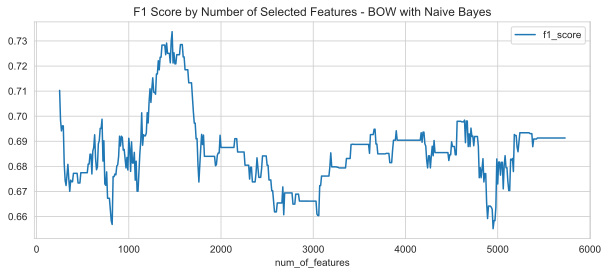

In [29]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [30]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

1420 1520 1


,num_of_features,f1_score,accuracy
122,1470,0.7336865,0.7360000
121,1460,0.7299072,0.7320000
116,1410,0.7291571,0.7320000
131,1560,0.7285664,0.7320000
132,1570,0.7285664,0.7320000


#### Get a more fine-grained look at the optimal number of features region

In [31]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

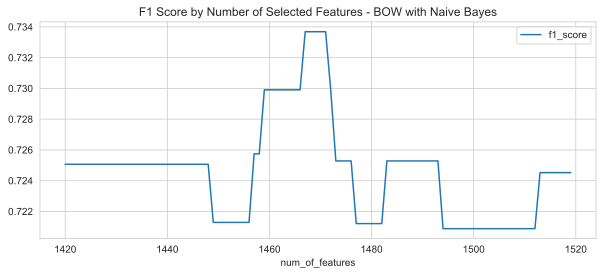

In [32]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [33]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

1470


,num_of_features,f1_score,accuracy
50,1470,0.7336865,0.7360000
47,1467,0.7336865,0.7360000
48,1468,0.7336865,0.7360000
49,1469,0.7336865,0.7360000
51,1471,0.7336865,0.7360000


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [34]:
model_nb_bow_opt = MultinomialNB()
rm_chi_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)

In [35]:
print(rm_chi_opt_bow.cm)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10 13  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 16  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  4 17  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4 20  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 12  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  8 13  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  3  8  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  6  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  8 12]]


In [36]:
print("Label" + rm_chi_opt_bow.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.75      0.47      0.58        19
 coffee-ordering-2       0.57      0.81      0.67        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.89      0.80      0.84        20
   movie-tickets-2       0.68      0.77      0.72        22
   movie-tickets-3       0.80      0.83      0.82        24
  pizza-ordering-1       0.77      0.71      0.74        14
  pizza-ordering-2       0.83      0.87      0.85        23
restaurant-table-1       0.86      0.55      0.67        22
restaurant-table-2       0.46      0.76      0.58        17
restaurant-table-3       0.62      0.50      0.55        16
       uber-lyft-1       0.86      0.40      0.55        15
       uber-lyft-2       0.60      0.92      0.73        13

          accuracy                           0.74       250
         macro avg       0.76    

In [37]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BOW", rm_chi_opt_bow, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.7243102,0.6960000,0.6838492,0.6960000
1,BOW Naive Bayes Optimal Features Selected: 1470,BOW,0.7656818,0.7360000,0.7336865,0.7360000


## Bag of N-Grams Feature Extraction

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(X_train)
bv_matrix = bv_matrix.toarray()
bv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [39]:
# get all unique words in the corpus
vocab = bv.get_feature_names()
# show document feature vectors
pd.DataFrame(bv_matrix, columns=vocab)

,abbey drive,abigail lives,abigails whoops,abigails yes,ability scan,able accommodate,able attend,able come,able find,able get,able make,able meet,able order,able pick,able place,...,yummy great,yummy pizza,yup appears,yup awesome,yup electronically,yup problem,yupno sorry,yusho ooo,zip code,zipcode would,ziti pasta,ziti perfect,zoo kuhio,zoo right,zoo want
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
746,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
747,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
# Get Bag of N-Gram features
X_train_bong = bv.fit_transform(X_train).toarray()
X_test_bong = bv.transform(X_test).toarray()
print (X_train_bong.shape) 
print (X_test_bong.shape) 
print (y_test.shape)

(750, 37534)
(250, 37534)
(250,)


## Bag of N-Grams Feature Benchmarking with Naive Bayes Classifier

In [41]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bong = MultinomialNB()
results_nb_bong = Build_Model(model_nb_bong, X_train_bong, y_train, X_test_bong, y_test)

In [42]:
# Save benchmark output
Save_Benchmark("Bag of N-Gram Naive Bayes baseline", "BONG", results_nb_bong, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Bag of N-Gram Naive Bayes baseline,BONG,0.6401657,0.6000000,0.5697283,0.6000000


In [43]:
from sklearn.metrics import confusion_matrix

results_nb_bong.cm

array([[17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0, 13, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3, 14,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  6, 16,  6,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  4, 18,  0,  0,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  1,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11, 22,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  3,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 16, 13,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12, 12]],
      dtype=int64)

In [44]:
from sklearn import metrics

print(results_nb_bong.report)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.94      0.97        18
 coffee-ordering-1       0.55      0.32      0.40        19
 coffee-ordering-2       0.48      0.75      0.59        16
      movie-finder       1.00      0.36      0.53        11
   movie-tickets-1       0.74      0.70      0.72        20
   movie-tickets-2       0.53      0.73      0.62        22
   movie-tickets-3       0.69      0.75      0.72        24
  pizza-ordering-1       0.60      0.21      0.32        14
  pizza-ordering-2       0.67      0.96      0.79        23
restaurant-table-1       0.50      0.14      0.21        22
restaurant-table-2       0.36      0.76      0.49        17
restaurant-table-3       0.80      0.50      0.62        16
       uber-lyft-1       0.67      0.13      0.22        15
       uber-lyft-2       0.48      0.92      0.63        13

          accuracy                           0.60       250
         macro avg       0.65      0.58      0.56       25

## Feature Selection: Bag of N-Gram Features with Naive Bayes Model Using Chi-Squared Selector

#### Iterate through number of features and get benchmark results

In [45]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    results_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

#### Plot f1-score by number of selected features

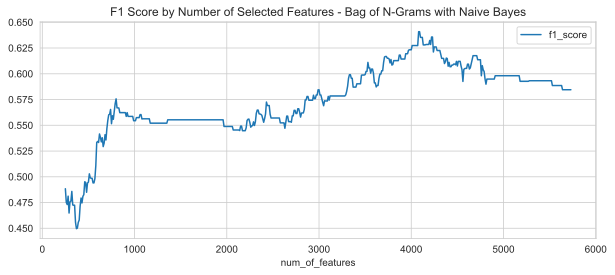

In [46]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [47]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

4030 4130 1


,num_of_features,f1_score,accuracy
383,4080,0.6408318,0.6480000
384,4090,0.6408318,0.6480000
398,4230,0.6356765,0.6440000
397,4220,0.6356765,0.6440000
386,4110,0.6353214,0.6440000


#### Get a more fine-grained look at the optimal number of features region

In [48]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

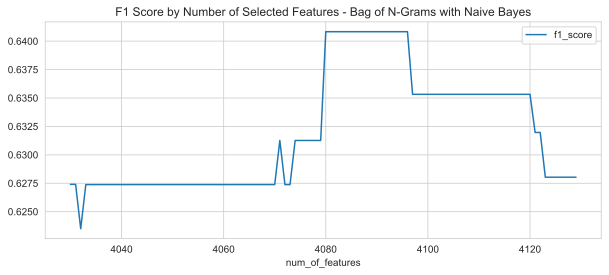

In [49]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [50]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
50,4080,0.6408318,0.6480000
56,4086,0.6408318,0.6480000
54,4084,0.6408318,0.6480000
53,4083,0.6408318,0.6480000
52,4082,0.6408318,0.6480000


## Benchmark Bag of N-Grams With Optimal Features Selected using Naive Bayes Model

In [51]:
model_nb_bong_opt = MultinomialNB()
results_bong_opt = SelectBestModelFeatures_Chi(model_nb_bong_opt, Opt_no_of_feat, X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)

In [52]:
print(results_bong_opt.report)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.55      0.32      0.40        19
 coffee-ordering-2       0.46      0.69      0.55        16
      movie-finder       1.00      0.64      0.78        11
   movie-tickets-1       0.87      0.65      0.74        20
   movie-tickets-2       0.58      0.68      0.62        22
   movie-tickets-3       0.72      0.88      0.79        24
  pizza-ordering-1       0.73      0.57      0.64        14
  pizza-ordering-2       0.77      0.87      0.82        23
restaurant-table-1       0.64      0.32      0.42        22
restaurant-table-2       0.39      0.71      0.50        17
restaurant-table-3       0.62      0.50      0.55        16
       uber-lyft-1       0.71      0.33      0.45        15
       uber-lyft-2       0.52      0.85      0.65        13

          accuracy                           0.65       250
         macro avg       0.68      0.64      0.64       25

In [53]:
# Save benchmark output
Save_Benchmark("Bag of N-Gram Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BONG", results_bong_opt, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Bag of N-Gram Naive Bayes baseline,BONG,0.6401657,0.6000000,0.5697283,0.6000000
1,Bag of N-Gram Naive Bayes Optimal Features Selected: 4080,BONG,0.6797066,0.6480000,0.6408318,0.6480000


## TF-IDF Feature Extraction

In [54]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 5221)
(250, 5221)


In [55]:
vocab_tfidf = count_vect.get_feature_names()
pd.DataFrame(X_train_tfidf.toarray(), columns=vocab_tfidf)

,abbey,abigail,abigails,ability,able,abosolutly,abotu,abrams,abruptly,absoluteley,absolutely,abyss,ac,acadia,accelerate,...,youtube,youve,youwould,yucca,yukon,yum,yummier,yummy,yup,yupno,yusho,zip,zipcode,ziti,zoo
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
1,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
3,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
4,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
746,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
747,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
748,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [56]:
clf = MultinomialNB()
results_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Make Some Predictions

In [57]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 5221)


array(['auto-repair-appt-1'], dtype='<U18')

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [58]:
from sklearn.metrics import confusion_matrix

results_nb_tfidf.cm

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 16, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5, 18,  5,  3,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  2,  2, 14,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  3, 20,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9, 23,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 17, 13, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  5,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 12]],
      dtype=int64)

In [59]:
from sklearn import metrics

print("Label" + results_nb_tfidf.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.67      0.11      0.18        19
 coffee-ordering-2       0.47      0.94      0.62        16
      movie-finder       0.00      0.00      0.00        11
   movie-tickets-1       0.56      0.90      0.69        20
   movie-tickets-2       0.74      0.64      0.68        22
   movie-tickets-3       0.74      0.83      0.78        24
  pizza-ordering-1       1.00      0.36      0.53        14
  pizza-ordering-2       0.72      1.00      0.84        23
restaurant-table-1       0.67      0.09      0.16        22
restaurant-table-2       0.32      0.76      0.45        17
restaurant-table-3       0.45      0.31      0.37        16
       uber-lyft-1       0.71      0.33      0.45        15
       uber-lyft-2       0.60      0.92      0.73        13

          accuracy                           0.61       250
         macro avg       0.62    

In [60]:
# Save benchmark output
Save_Benchmark("TF-IDF Naive Bayes Baseline", "TF-IDF", results_nb_tfidf, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,TF-IDF Naive Bayes Baseline,TF-IDF,0.6391206,0.6080000,0.5563710,0.6080000


## Feature Selection - TF-IDF with Naive Bayes

In [61]:
rows = []
scaler_max_abs = MaxAbsScaler()
for i in range(50, 4850, 100): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test, scaler_max_abs)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

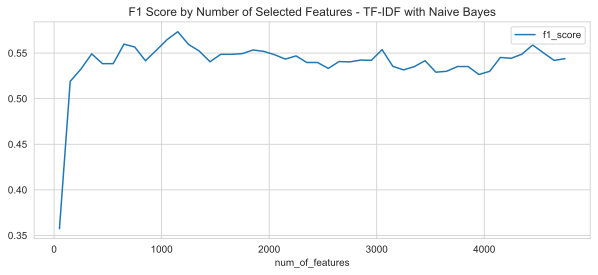

In [62]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [63]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

1100 1200 1


,num_of_features,f1_score,accuracy
11,1150,0.5734398,0.6320000
10,1050,0.5646994,0.6200000
6,650,0.5598063,0.6000000
12,1250,0.5595228,0.6160000
44,4450,0.5588746,0.6120000


#### Take closer look at region around optimal features

In [64]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test, scaler_max_abs)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

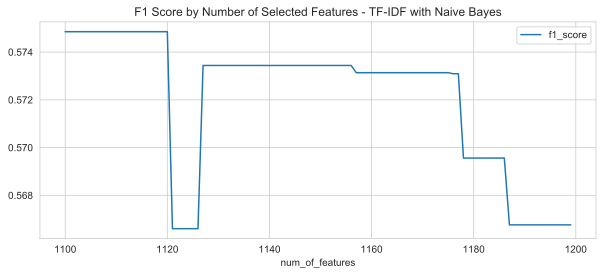

In [65]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [66]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
0,1100,0.5748536,0.6280000
11,1111,0.5748536,0.6280000
1,1101,0.5748536,0.6280000
20,1120,0.5748536,0.6280000
18,1118,0.5748536,0.6280000


## Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [67]:
results_tf_nb_opt = SelectBestModelFeatures_Chi(clf, Opt_no_of_feat, X_train_tfidf, y_train, X_test_tfidf, y_test, scaler_max_abs)
# Save benchmark output
Save_Benchmark("TF-IDF Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "TF-IDF", results_tf_nb_opt, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,TF-IDF Naive Bayes Baseline,TF-IDF,0.6391206,0.6080000,0.5563710,0.6080000
1,TF-IDF Naive Bayes Optimal Features Selected: 1100,TF-IDF,0.7315170,0.6280000,0.5748536,0.6280000


#### Metrics For Each Class

In [68]:
from sklearn import metrics
print("Label" + results_tf_nb_opt.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.67      0.11      0.18        19
 coffee-ordering-2       0.47      0.94      0.62        16
      movie-finder       1.00      0.09      0.17        11
   movie-tickets-1       0.70      0.80      0.74        20
   movie-tickets-2       0.68      0.68      0.68        22
   movie-tickets-3       0.66      0.88      0.75        24
  pizza-ordering-1       1.00      0.29      0.44        14
  pizza-ordering-2       0.70      1.00      0.82        23
restaurant-table-1       1.00      0.05      0.09        22
restaurant-table-2       0.36      0.82      0.50        17
restaurant-table-3       0.47      0.44      0.45        16
       uber-lyft-1       1.00      0.47      0.64        15
       uber-lyft-2       0.65      1.00      0.79        13

          accuracy                           0.63       250
         macro avg       0.74    

## Word2Vec Feature Extraction

In [69]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pizza', 'terminator', 'star', 'east', 'korean','playing']}
similar_words

{'pizza': ['topping', 'dominos', 'toppings', 'delivery', 'pepperoni'],
 'terminator': ['judgment', 'abyss', 'avatar', 'directed', 'sigourney'],
 'star': ['wars', 'jedi', 'previous', 'v', 'blade'],
 'east': ['broadway', 'chicago', 'abigail', 'avenue', 'amc'],
 'korean': ['bbgo', 'lauderhill', 'bbq', 'manna', 'pig'],
 'playing': ['theaters', 'showtimes', 'theatre', 'cinematic', 'demento']}

#### Visualizing word embeddings

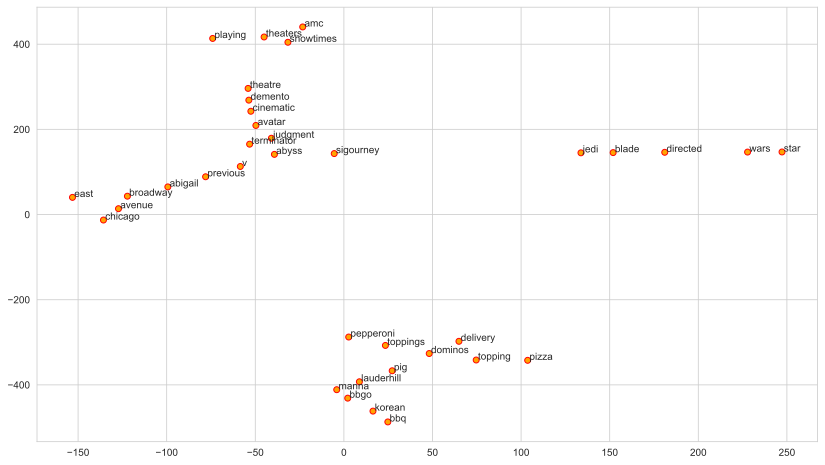

In [70]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [71]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [72]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

#### Do a Word Test

In [73]:
w2v_model.wv['jedi']

array([-0.61319655,  0.47387147, -0.37309206,  0.14999261,  0.35135588,
        0.15965605,  0.38147902,  0.23856251, -0.690889  ,  0.3051065 ,
        0.4968106 , -0.08522658, -0.24396375, -0.03538733,  0.52420795,
        0.01591964,  0.26926264,  0.2377094 , -0.26762655, -0.37251383,
        0.0923042 , -0.09211428, -0.4238184 , -0.32513317,  0.8353903 ,
        0.3043867 , -0.04710242, -0.7427688 ,  0.6019182 ,  0.25728709,
       -0.7213822 , -0.4433395 , -0.41999096, -0.00063808, -0.19905502,
       -0.24435574, -0.09899515,  0.4967316 ,  0.00074265, -0.12432971,
        0.1138543 ,  0.2410274 ,  0.17216589,  0.05302939, -0.03130481,
        0.0530332 , -0.2905535 , -0.52553695, -0.28029898, -0.42498457,
       -0.02312349, -0.13852257, -0.00542112,  0.53716624, -0.8460976 ,
        0.11046489, -0.11189845,  0.09935278, -0.34928927, -0.09226485,
       -0.1648938 ,  0.83630127, -0.16211446,  0.41371793,  0.4462055 ,
       -0.25457108,  0.09165927,  0.04388133, -0.4165596 ,  0.04

#### Build framework for getting document level embeddings

In [74]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [75]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.1485421,-0.7538016,-0.1134053,0.6662195,-0.7246261,-0.7991774,-0.5115496,0.1824114,0.6560699,-0.7206530,-0.2054649,0.4597724,0.5525629,0.0213620,-0.3256565,...,0.4053718,-0.3727004,0.0782410,0.0970477,0.0698585,-0.8716509,-0.1177295,-0.2618363,-0.8949518,-0.3898905,-0.4477316,-0.6339689,-0.1955280,-0.4779007,-0.2186819
1,-0.0607553,1.0541956,0.4737130,-0.1523951,0.8053292,-0.4724531,0.0109847,-0.0374870,0.1855697,0.0516603,-0.0084349,-0.0452377,-0.2025987,0.6360932,-0.4247550,...,-0.3141208,0.2796801,0.6528099,-0.1768731,-0.3410071,-0.3468805,0.0265353,0.3773893,0.4371449,-0.4313515,0.6189898,0.0581974,-0.2598901,-0.1812492,-0.2534438
2,1.0977465,0.2787353,0.1757089,0.1846928,0.1721655,-0.5292627,-0.4936659,-0.5354583,0.1182661,0.9190141,-0.0212562,0.1572086,-0.8481135,0.5290564,0.1768160,...,-0.2977565,-0.1036247,-0.0966276,-1.2309000,-0.5177864,-0.3462019,1.2682528,-0.5254877,0.1210109,-0.3101588,0.9440062,-0.3934053,-0.1125975,-0.8450115,0.1949672
3,0.5198169,0.1662873,-0.9000216,-0.3820015,-0.5178834,0.2152452,0.3997748,-0.1660945,0.1260828,1.2495424,0.6054741,-0.5418217,-0.1087384,-0.6968853,0.5585704,...,-0.0937409,0.0885866,0.5381762,-0.7950464,0.0774281,-0.3589838,0.2230919,0.2119676,0.1618903,-0.0312084,0.1629608,-0.0443770,-0.4477863,0.1457826,-0.5599681
4,0.9221550,0.6896073,-0.1255608,-0.7041550,-1.0570785,-0.2343613,-0.3812177,-0.4385283,0.3320740,0.6040448,-0.5757979,-0.1354633,-0.1514468,-0.0200478,-0.6737193,...,0.0860299,-0.6178099,1.1070708,-0.4130673,-0.2364017,-0.4032098,0.7674741,-0.1994137,0.2186709,-0.8004017,0.4871556,0.0780544,0.1773675,-0.7858883,-0.6119339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.7777841,0.2974014,0.0622340,0.0823392,0.1991102,-0.0638373,0.3864126,-0.5715278,0.2877930,1.1085774,-0.3242853,0.1342608,-0.1094064,0.0176052,-0.1996050,...,0.2249702,0.3456248,-0.1886711,-0.5371737,-0.1926461,-0.0257408,0.9117838,-0.3512136,0.0910150,-0.8739006,1.0386050,0.2087816,0.0839641,-0.4121912,0.4063788
746,1.3327909,1.0493979,0.4724289,-0.1673032,-0.3365210,-0.0422698,0.4593206,0.7411319,-0.0931501,0.3031758,0.4161615,-0.6679423,-0.0765548,-0.3926104,0.0936788,...,-0.4422110,0.2345711,0.4616963,-0.2367262,-0.4065232,-0.0415200,-0.1547732,-0.1611977,0.3142383,0.0682614,0.1784165,0.0304424,-0.1986420,0.1519098,0.1475856
747,1.1111339,0.1478708,0.4795337,0.4620506,0.4769705,-0.6561098,-0.6760464,-0.5175237,0.0581993,1.0645383,-0.4506287,0.5397216,-0.4282683,0.2570861,0.2874751,...,-0.0162533,-0.6011503,0.0397729,-1.0320552,-0.4482324,0.0073839,0.9838745,-0.7497380,0.1730990,-0.8693140,0.4739903,0.2604035,0.0958823,-0.8939016,-0.1971465
748,0.7482316,-0.0639104,1.0775760,0.2059366,-0.5521994,-0.7394230,-0.3476531,-1.0591926,1.3320585,0.5411949,-0.3872742,0.3025306,-0.6207048,0.1300216,0.1434333,...,0.4883057,-0.5642756,1.1355059,-0.3777779,-0.1394189,-1.1821305,1.1121068,0.6864290,-0.2048172,-0.0566538,0.6695226,-0.0267437,-0.4848227,-0.2945383,-1.0686285


In [76]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


## Word2vec Feature Benchmarking with Naive Bayes Classifier

In [77]:
from sklearn.naive_bayes import GaussianNB

scaler_min_max = MinMaxScaler()
#model_w2v_nb = MultinomialNB()
model_w2v_nb = GaussianNB()
results_nb_w2v = SelectBestModelFeatures_Chi(model_w2v_nb, 100, w2v_feature_array, y_train, w2v_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec Naive Bayes Baseline", "Word2Vec", results_nb_w2v, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Word2Vec Naive Bayes Baseline,Word2Vec,0.6512414,0.6480000,0.6379862,0.6480000


In [78]:
results_nb_w2v.cm

array([[16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  3,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 13,  9,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 11,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  2, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  9,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 20,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  1,  1,  0,  0,  0,  0,  2,  2,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0, 14,  8,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  7, 15,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7, 10]],
      dtype=int64)

In [79]:
print("Label" + results_nb_w2v.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.89      0.94        18
 coffee-ordering-1       0.67      0.74      0.70        19
 coffee-ordering-2       0.75      0.56      0.64        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.54      0.65      0.59        20
   movie-tickets-2       0.52      0.50      0.51        22
   movie-tickets-3       0.85      0.71      0.77        24
  pizza-ordering-1       0.69      0.64      0.67        14
  pizza-ordering-2       0.80      0.87      0.83        23
restaurant-table-1       0.25      0.09      0.13        22
restaurant-table-2       0.33      0.47      0.39        17
restaurant-table-3       0.54      0.94      0.68        16
       uber-lyft-1       0.73      0.53      0.62        15
       uber-lyft-2       0.59      0.77      0.67        13

          accuracy                           0.65       250
         macro avg       0.66    

## Feature Selection - Word2Vec Features with Naive Bayes Model

In [80]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_w2v_nb, i, w2v_feature_array, y_train, w2v_test_array, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

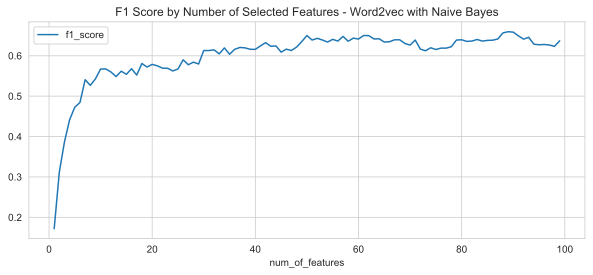

In [81]:
sel_nb_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec with Naive Bayes", figsize=(10, 4))

In [82]:
Opt_no_of_feat = int(sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
88,89,0.6595766,0.6640000
89,90,0.6585284,0.6640000
87,88,0.6564945,0.6600000
60,61,0.6501595,0.6560000
49,50,0.6500877,0.6560000


In [83]:
results_nb_w2v = SelectBestModelFeatures_Chi(model_w2v_nb, Opt_no_of_feat, w2v_feature_array, y_train, w2v_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "Word2Vec", results_nb_w2v, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Word2Vec Naive Bayes Baseline,Word2Vec,0.6512414,0.6480000,0.6379862,0.6480000
1,Word2Vec Naive Bayes Optimal Features Selected: 89,Word2Vec,0.6792014,0.6640000,0.6595766,0.6640000


## Word2vec features Extraction with Fastext Model

In [84]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [85]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['engine', 'emergency', 'quick', 'initial', 'drop'],
 'pizza': ['crust', 'pepperoni', 'toppings', 'cheese', 'sausage'],
 'terminator': ['nevermind', 'meant', 'near', 'peppermint', 'terry'],
 'star': ['wars', 'starring', 'galaxy', 'episode', 'recommended'],
 'audi': ['date', 'maggianos', 'reserve', 'avengers', 'latest'],
 'east': ['broadway', 'chicago', 'river', 'e', 'ca'],
 'korean': ['barbecue', 'bbq', 'cannot', 'chinese', 'nevermind'],
 'playing': ['tickets', 'movie', 'theater', 'showing', 'theaters']}

#### PCA on Fasttext Model

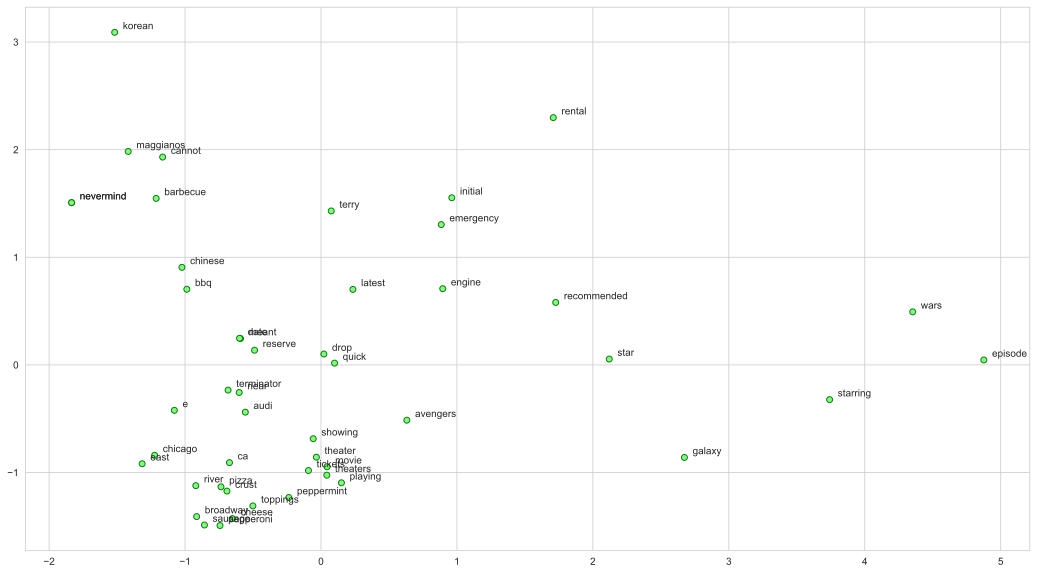

In [86]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [87]:
print(P.shape)

(48, 2)


In [88]:
ft_model.wv['rental']

array([-0.33776394, -0.6843006 , -0.16247052,  0.8312586 ,  0.45984277,
        0.4911854 , -0.48905125,  0.71497005, -0.01917698, -0.7456548 ,
        0.49946365, -0.48202646,  0.32340884,  0.3558344 , -0.1113463 ,
        0.68673897,  0.13427407,  0.33644703, -0.07808826,  0.06823302,
        0.41038665,  0.24202193, -0.32791317,  0.39665052, -0.21816811,
        0.9348781 , -0.6606429 ,  0.2145046 ,  0.14715776,  1.5907197 ,
       -0.0302495 , -0.15634634,  0.23006053, -1.0079712 , -0.9926084 ,
        0.2106113 ,  0.6795182 ,  0.74782926,  0.06794191,  0.9083036 ,
        0.01038817, -0.10160724, -0.15713942,  0.15752201,  0.3490664 ,
       -0.00267603, -0.36777234, -0.00805119,  0.9850003 ,  0.8272897 ,
       -0.3289412 ,  0.96928287, -0.8428107 ,  0.92160636, -1.0961428 ,
        1.166322  , -0.1738865 ,  0.76749235, -0.98820466, -0.14863145,
        0.7573479 , -0.36060157, -0.6595195 ,  0.02580478,  0.14636385,
        0.25320318,  0.03746502, -0.50278133, -0.85067034, -0.09

In [89]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.2926925
0.8197969


In [90]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies


## Word2Vec Features from Fastext Benchmarking with Naive Bayes Model

In [91]:
w2v_ft_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=ft_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.1485421,-0.7538016,-0.1134053,0.6662195,-0.7246261,-0.7991774,-0.5115496,0.1824114,0.6560699,-0.7206530,-0.2054649,0.4597724,0.5525629,0.0213620,-0.3256565,...,0.4053718,-0.3727004,0.0782410,0.0970477,0.0698585,-0.8716509,-0.1177295,-0.2618363,-0.8949518,-0.3898905,-0.4477316,-0.6339689,-0.1955280,-0.4779007,-0.2186819
1,-0.0607553,1.0541956,0.4737130,-0.1523951,0.8053292,-0.4724531,0.0109847,-0.0374870,0.1855697,0.0516603,-0.0084349,-0.0452377,-0.2025987,0.6360932,-0.4247550,...,-0.3141208,0.2796801,0.6528099,-0.1768731,-0.3410071,-0.3468805,0.0265353,0.3773893,0.4371449,-0.4313515,0.6189898,0.0581974,-0.2598901,-0.1812492,-0.2534438
2,1.0977465,0.2787353,0.1757089,0.1846928,0.1721655,-0.5292627,-0.4936659,-0.5354583,0.1182661,0.9190141,-0.0212562,0.1572086,-0.8481135,0.5290564,0.1768160,...,-0.2977565,-0.1036247,-0.0966276,-1.2309000,-0.5177864,-0.3462019,1.2682528,-0.5254877,0.1210109,-0.3101588,0.9440062,-0.3934053,-0.1125975,-0.8450115,0.1949672
3,0.5198169,0.1662873,-0.9000216,-0.3820015,-0.5178834,0.2152452,0.3997748,-0.1660945,0.1260828,1.2495424,0.6054741,-0.5418217,-0.1087384,-0.6968853,0.5585704,...,-0.0937409,0.0885866,0.5381762,-0.7950464,0.0774281,-0.3589838,0.2230919,0.2119676,0.1618903,-0.0312084,0.1629608,-0.0443770,-0.4477863,0.1457826,-0.5599681
4,0.9221550,0.6896073,-0.1255608,-0.7041550,-1.0570785,-0.2343613,-0.3812177,-0.4385283,0.3320740,0.6040448,-0.5757979,-0.1354633,-0.1514468,-0.0200478,-0.6737193,...,0.0860299,-0.6178099,1.1070708,-0.4130673,-0.2364017,-0.4032098,0.7674741,-0.1994137,0.2186709,-0.8004017,0.4871556,0.0780544,0.1773675,-0.7858883,-0.6119339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.7777841,0.2974014,0.0622340,0.0823392,0.1991102,-0.0638373,0.3864126,-0.5715278,0.2877930,1.1085774,-0.3242853,0.1342608,-0.1094064,0.0176052,-0.1996050,...,0.2249702,0.3456248,-0.1886711,-0.5371737,-0.1926461,-0.0257408,0.9117838,-0.3512136,0.0910150,-0.8739006,1.0386050,0.2087816,0.0839641,-0.4121912,0.4063788
746,1.3327909,1.0493979,0.4724289,-0.1673032,-0.3365210,-0.0422698,0.4593206,0.7411319,-0.0931501,0.3031758,0.4161615,-0.6679423,-0.0765548,-0.3926104,0.0936788,...,-0.4422110,0.2345711,0.4616963,-0.2367262,-0.4065232,-0.0415200,-0.1547732,-0.1611977,0.3142383,0.0682614,0.1784165,0.0304424,-0.1986420,0.1519098,0.1475856
747,1.1111339,0.1478708,0.4795337,0.4620506,0.4769705,-0.6561098,-0.6760464,-0.5175237,0.0581993,1.0645383,-0.4506287,0.5397216,-0.4282683,0.2570861,0.2874751,...,-0.0162533,-0.6011503,0.0397729,-1.0320552,-0.4482324,0.0073839,0.9838745,-0.7497380,0.1730990,-0.8693140,0.4739903,0.2604035,0.0958823,-0.8939016,-0.1971465
748,0.7482316,-0.0639104,1.0775760,0.2059366,-0.5521994,-0.7394230,-0.3476531,-1.0591926,1.3320585,0.5411949,-0.3872742,0.3025306,-0.6207048,0.1300216,0.1434333,...,0.4883057,-0.5642756,1.1355059,-0.3777779,-0.1394189,-1.1821305,1.1121068,0.6864290,-0.2048172,-0.0566538,0.6695226,-0.0267437,-0.4848227,-0.2945383,-1.0686285


In [92]:
w2v_ft_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=ft_model,
                                             num_features=feature_size)

In [93]:
model_ft_nb = GaussianNB()
results_nb_ft = SelectBestModelFeatures_Chi(model_ft_nb, 100, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec Fastext Naive Bayes Baseline", "Word2Vec_FT", results_nb_ft, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Word2Vec Fastext Naive Bayes Baseline,Word2Vec_FT,0.6491872,0.5960000,0.5457620,0.5960000


## Word2Vec from Fastext Model Feature Selction with Naive Bayes Model

In [94]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_ft_nb, i, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_ft_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

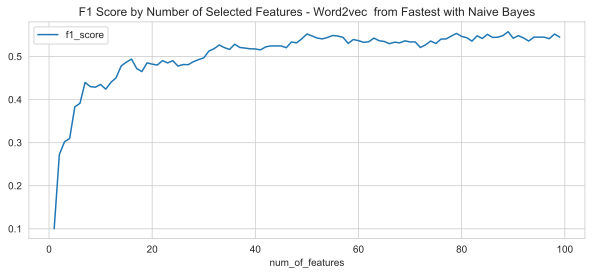

In [95]:
sel_nb_ft_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec  from Fastest with Naive Bayes", figsize=(10, 4))

In [96]:
Opt_no_of_feat = int(sel_nb_ft_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_ft_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
88,89,0.5575331,0.6080000
78,79,0.5535809,0.6040000
49,50,0.5522676,0.6040000
97,98,0.5521085,0.6040000
84,85,0.5514654,0.6040000


## Benchmarking Word2Vec Fastext with Naive Bayes on Optimal number of Features

In [97]:
results_nb_ft = SelectBestModelFeatures_Chi(model_ft_nb, Opt_no_of_feat, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec from Fastest Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "Word2Vec_FT", results_nb_ft, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Word2Vec Fastext Naive Bayes Baseline,Word2Vec_FT,0.6491872,0.5960000,0.5457620,0.5960000
1,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 89,Word2Vec_FT,0.6491047,0.6080000,0.5575331,0.6080000


## Feature Extraction: Glove Word Embeddings

#### GloVe Embeddings with spaCy

In [98]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [99]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
squids,-0.1416500,-0.4900700,-0.2714800,-0.2751200,-0.3296700,0.1522900,-0.7566000,0.2574700,-0.0171810,-0.6493200,0.0949130,-0.2065700,0.6558300,0.5114600,-0.5274500,...,-0.0510370,0.2185700,-0.4828700,0.3778100,-0.4065200,-0.3211800,-0.3257000,-0.3544200,-0.4056900,-0.7556100,0.2134900,-0.3636400,-0.3162300,-0.1715900,-0.1237700
trick,-0.3567300,-0.0970000,-0.0495100,-0.5149500,-0.5727700,-0.0803820,0.0085407,-0.0378780,-0.0876820,1.3408000,-0.4515000,0.2536200,0.0094391,0.1565700,0.2703700,...,-0.4440600,-0.0913330,0.0487760,0.5023200,0.2489100,-0.5489400,0.2001600,-0.1035400,-0.0072718,0.2440600,0.0589010,0.3156800,0.2742900,0.3108900,0.3618700
environment,-0.0950420,-0.0716570,0.1013300,-0.2493700,-0.0686150,0.3422400,-0.0941900,0.1319500,-0.0805160,2.2076001,-0.6136900,-0.5522600,-0.3553600,0.7258800,-0.3516400,...,-0.7580100,0.4380300,-0.2827000,0.4365400,-0.6892800,0.0360140,0.3798200,0.0444010,0.0809230,-0.2396200,0.3994400,-0.0054160,0.1742600,-0.2539400,-0.0380950
police,-0.3551400,0.3158700,0.2300100,0.0760790,0.1343300,-0.1681400,0.0029444,-0.2995100,-0.2692700,3.7609000,-0.2856400,-0.5034900,0.4485300,-0.0250250,-1.2502000,...,0.2038500,0.0506930,0.2899600,-0.3540400,-0.2213000,-0.3471600,-0.3215900,0.8599900,0.3900900,-0.3777400,-0.0890210,-0.0573730,-0.1440100,-0.0409000,0.3320500
walk,0.8273700,-0.2852200,-0.4585500,0.0555420,0.5366800,-0.0032239,-0.4037900,0.1069100,-0.0010172,2.7567000,-0.5361900,-0.1166700,-0.0463610,0.1498200,-0.5372200,...,-0.1633900,0.0131600,-0.2322200,0.3970100,0.0909650,0.1813200,0.1754900,-0.0337610,0.1325600,-0.0118310,0.1276000,0.8647400,0.5683200,0.0483950,0.1726200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nearest,0.6526300,-0.5824000,-0.4785700,0.5859600,1.2142000,-0.8135100,-0.0470290,0.3684600,-0.1962200,1.8520000,-0.8067200,-0.0132940,-0.0693920,-0.6444800,-0.0245130,...,-0.3565000,-0.0670680,-0.5627500,-0.3051100,0.2533300,0.0660570,-0.1418000,0.0534190,-0.1783000,0.2582100,-0.0531730,0.3936500,-0.3523800,-0.4738000,0.8752500
otaku,0.1655200,-0.7392600,0.0124930,0.2833700,0.3289100,-0.3171300,0.1126300,0.1379800,-0.2698500,-0.1802300,-0.6001600,-0.7537400,-0.4315500,0.0545380,0.0984980,...,0.2522900,-0.0532400,-0.5424900,-0.2630200,0.1163200,0.0064691,-0.0253020,0.1545800,0.1866200,0.1223500,-0.6561200,-0.1312700,-0.0513700,-0.3914900,0.0767010
hows,-0.0827805,0.4671450,-0.2518400,-0.0069316,0.0534700,0.1997800,0.1151395,-0.0335500,0.0079945,2.1429501,-0.3422050,-0.3954800,-0.0583445,-0.1208390,-0.0697733,...,0.0295795,0.1647080,-0.0210125,0.0060550,-0.0537675,0.1682685,0.1571350,-0.1178629,0.0222206,0.4111600,-0.0328555,-0.1035665,-0.0373350,0.2918600,-0.0941300
grande,-0.5106100,-0.4051400,0.1085600,0.0406320,0.5929300,0.3775100,0.0976700,0.5245900,-0.1522000,0.0287590,-0.2641500,0.3656200,0.1530400,-0.2478800,0.0928850,...,-0.0661460,0.7982700,-0.3311400,-0.1452600,-0.2077500,0.4021600,-0.0185490,-0.4407600,0.3404100,1.1466000,0.2452800,0.4455200,-0.8669800,-0.4149600,0.0071492


In [142]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words_test])
print(word_glove_vectors_test.shape)

(2798, 300)


#### GloVe Embeddings with Flair

In [101]:
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings

glove_embedding = WordEmbeddings('glove')
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

In [102]:
from flair.embeddings import Sentence

# create an example sentence
sentence = Sentence('The grass is green . And the sky is blue .')
# embed the sentence with our document embedding
document_embeddings.embed(sentence)
# now check out the embedded sentence.
print(sentence.get_embedding())

tensor([-0.3295,  0.0338, -0.3100,  0.1587,  0.0474,  0.2263, -0.0085,  0.1789,
         0.2933,  0.0284,  0.3626,  0.2725,  0.0023,  0.1300,  0.1105,  0.3053,
         0.1394, -0.1813,  0.0213,  0.1389, -0.2288,  0.1679,  0.0748, -0.2080,
        -0.2284,  0.1380,  0.1357, -0.0132,  0.0520, -0.2992, -0.1540, -0.2944,
        -0.0828, -0.2216,  0.2201,  0.0220,  0.0597, -0.1865,  0.0641, -0.1658,
         0.3318,  0.1023, -0.3464, -0.2252, -0.1636, -0.0290, -0.2516,  0.0935,
         0.1478, -0.2537,  0.0554, -0.3215, -0.3083,  0.2428, -0.2287, -0.2178,
         0.0401,  0.1988, -0.2992,  0.0794,  0.3934, -0.0641, -0.2686, -0.1424,
         0.0418,  0.1350, -0.3074,  0.6329,  0.0074,  0.0229, -0.3291, -0.4170,
         0.0965, -0.2067, -0.0198,  0.2539, -0.2697,  0.1471, -0.0758, -0.1574,
        -0.1655, -0.1184,  0.0094,  0.1366,  0.4608, -0.0931,  0.3247,  0.3616,
        -0.2578,  0.0574,  0.4627, -0.3560, -0.0832,  0.1242, -0.3111,  0.0770,
         0.0162, -0.1376,  0.2241,  0.01

In [103]:
from nltk.tokenize import word_tokenize

def Get_Glove_Features(corpus):
    dataset_size = len(corpus)
    X = np.zeros((dataset_size, 128))
    for iter in range(0, dataset_size):
        text = corpus[iter]
        sentence = Sentence(text)
        document_embeddings.embed(sentence)
        X[iter] = sentence.get_embedding().detach().numpy()
    return X

In [104]:
x_train_glove = Get_Glove_Features(X_train)
x_test_glove = Get_Glove_Features(X_test)
print(x_train_glove.shape, x_test_glove.shape)

(750, 128) (250, 128)


In [105]:
pd.DataFrame(x_test_glove)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.0117013,0.0617747,-0.0950755,0.1091563,-0.1017631,0.1596720,-0.0589565,0.2751329,0.2228780,0.0728145,0.1217980,-0.2213324,0.0309835,0.1872737,-0.1791847,...,-0.5104705,-0.0078470,-0.0831146,0.0714433,-0.1835432,-0.0898436,0.0687750,0.2477705,0.0838807,0.1205176,0.4155601,0.2521685,0.3358440,0.0998841,-0.0211280
1,0.0841807,-0.0620297,-0.1189875,-0.2875261,-0.0688366,0.0544598,-0.0740813,0.1240726,0.2370038,-0.3685208,0.0081649,0.1720139,0.2636593,0.3350509,-0.0955308,...,-0.1906378,-0.2290410,-0.3105431,-0.0933061,-0.1229945,-0.1728213,0.2242400,0.2069762,0.1645058,-0.2629146,0.1243051,-0.1179824,0.3480213,0.1397902,0.0999395
2,0.5025941,-0.0467734,-0.0588523,0.0163325,-0.1757609,-0.0487810,-0.0511439,0.3398829,-0.1275912,-0.1881538,0.0756296,-0.0493684,0.1849568,0.1172654,-0.0445877,...,-0.3164518,-0.3373530,0.0266909,0.0341118,-0.2056447,0.2590645,-0.1101436,0.3480978,-0.1572295,-0.1003006,0.1555523,0.2775161,0.2021939,0.0394494,-0.0737516
3,-0.0227185,-0.0103282,-0.2404889,-0.1926294,-0.0662659,0.0504382,-0.2372182,0.1978792,0.2782909,-0.2748538,0.2242014,-0.0039797,0.4634213,0.2190981,0.0749667,...,-0.3986456,-0.1960211,-0.1547213,-0.1356924,-0.4575658,-0.0153032,0.0038569,0.1053351,-0.0102704,-0.0650678,-0.1560592,0.1723098,0.4841015,0.1260836,0.1324164
4,-0.3222020,0.1958944,-0.4945650,-0.0861031,-0.0720596,0.1695689,-0.1488497,0.1885127,0.1484847,-0.0574512,0.3483195,-0.0481694,0.0474820,0.0284749,0.0269960,...,-0.3586385,0.1120068,-0.1014663,0.0809911,-0.2634936,0.0184067,-0.1817474,0.3978114,0.0409611,0.1211918,0.1314168,0.2871761,0.3476427,0.0892936,0.1613087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.1313466,-0.2277337,-0.0699241,-0.1615932,-0.0721090,-0.0488684,-0.0867414,0.1764553,0.0073949,-0.2755411,0.0725538,0.0099354,0.2464064,0.3730648,-0.1010340,...,-0.1687075,-0.2945323,-0.2267397,0.0391903,-0.1036730,-0.0536422,0.1099728,0.2726082,0.0445608,-0.1795382,0.0782219,-0.0099661,0.2703265,0.0317660,0.0680796
246,-0.2333377,-0.0675329,-0.3608953,-0.0170508,-0.2104710,0.1508308,-0.1324217,0.1526401,0.2249017,-0.2749716,0.2272072,0.0731963,0.1389404,0.1775106,-0.0593418,...,-0.2426213,-0.1081695,0.0260374,-0.0802686,-0.3360917,-0.0931703,-0.1112932,0.3000403,0.3702413,0.0454275,0.2087247,0.1076339,0.4296308,0.1941992,0.0460027
247,-0.1406810,0.1325267,-0.1478698,-0.1698386,-0.2022910,0.0391697,0.0031608,0.0252157,0.3263749,-0.3046124,0.0568144,-0.0798995,0.1360346,0.2006923,0.0334616,...,-0.4038441,-0.1176340,0.0302633,-0.0429551,-0.3574593,-0.0629316,0.0148684,0.0992326,0.2415009,-0.0653614,0.1805281,0.0778138,0.4791604,0.0095679,-0.0495327
248,-0.1477484,-0.1279918,-0.3581616,-0.1365404,-0.1992545,-0.0465445,-0.2704552,0.1566750,0.1648552,-0.2836624,0.1158170,0.0562015,0.3353604,0.4025626,0.0245052,...,-0.1084716,-0.2739449,-0.1939565,0.0013533,-0.3172579,-0.1195750,-0.0452413,0.2963952,0.2149803,-0.1478659,0.1162257,0.0396105,0.3992071,0.2147059,0.1101324


In [106]:
from sklearn.naive_bayes import GaussianNB

model_glove_nb = GaussianNB()
results_nb_glove = Build_Model(model_glove_nb, x_train_glove, y_train, x_test_glove, y_test)
# Save benchmark output
# rows_benchmarks.append(["Glove with Naive Bayes All Features", f1_nb_glove, accuracy_nb_glove])
# df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
# df_benchmarks

In [107]:
print(results_nb_glove.report)

precision    recall  f1-score   support

auto-repair-appt-1       0.00      0.00      0.00        18
 coffee-ordering-1       0.04      0.05      0.05        19
 coffee-ordering-2       0.00      0.00      0.00        16
      movie-finder       0.05      0.09      0.06        11
   movie-tickets-1       0.20      0.25      0.22        20
   movie-tickets-2       0.08      0.05      0.06        22
   movie-tickets-3       0.26      0.21      0.23        24
  pizza-ordering-1       0.17      0.07      0.10        14
  pizza-ordering-2       0.12      0.17      0.14        23
restaurant-table-1       0.09      0.09      0.09        22
restaurant-table-2       0.00      0.00      0.00        17
restaurant-table-3       0.04      0.12      0.06        16
       uber-lyft-1       0.23      0.20      0.21        15
       uber-lyft-2       0.07      0.08      0.07        13

          accuracy                           0.10       250
         macro avg       0.10      0.10      0.09       25

## Feature Selection on Glove Features with Naive Bayes Model

In [108]:
rows = []
for i in range(1, 128, 1): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_glove_nb, i, x_train_glove, y_train, x_test_glove, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_glove_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

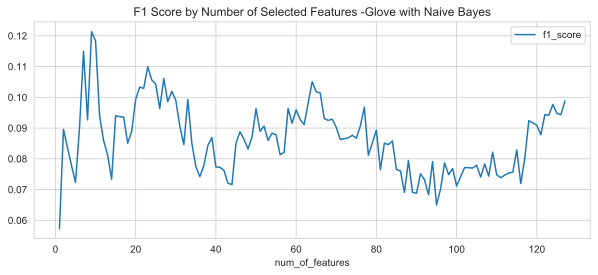

In [109]:
sel_nb_glove_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -Glove with Naive Bayes", figsize=(10, 4))

In [110]:
Opt_no_of_feat = int(sel_nb_glove_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_glove_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
8,9,0.1213404,0.1360000
9,10,0.1183812,0.1320000
6,7,0.1149553,0.1320000
22,23,0.1099455,0.1160000
26,27,0.1061084,0.1120000


In [111]:
results_nb_glove = SelectBestModelFeatures_Chi(model_glove_nb, Opt_no_of_feat, x_train_glove, y_train, x_test_glove, y_test, scaler_min_max)

# Save benchmark output
# Save_Benchmark("Glove Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "GloVe", results_nb_glove, False, False)
# df_benchmarks

#### Leave the Glove Feature result out for now since it clearly is problematic

## Combining Features

## Combine BOW and BAG of nGrams

In [112]:
def Get_Combined_Features(feat_1, feat_2):
    row_size = len(feat_1)
    col_size_1 = np.size(feat_1, axis=1)
    col_size_total = np.size(feat_1, axis=1) + np.size(feat_2, axis=1)
    X = np.zeros((row_size, col_size_total))
    #rint(X.shape, col_size_1, np.size(feat_2, axis=1), col_size)
    for i in range(0, row_size):
        for j in range(0, col_size_1):
            X[i, j] = feat_1[i, j]

        for k in range(col_size_1, col_size_total):
            X[i, k] = feat_2[i, k - col_size_1]
    return X

In [113]:
from numpy import column_stack

x_train_bow_norm, x_test_bow_norm = SelectAndScaleFeatures_Chi(np.size(X_train_bow, axis=1), X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
x_train_bong_norm, x_test_bong_norm = SelectAndScaleFeatures_Chi(np.size(X_train_bong, axis=1), X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)

x_train_bow_bong = Get_Combined_Features(x_train_bow_norm, x_train_bong_norm)
x_test_bow_bong = Get_Combined_Features(x_test_bow_norm, x_test_bong_norm)

#x_train_bow_bong = Get_Combined_Features(X_train_bow, X_train_bong)
#x_test_bow_bong = Get_Combined_Features(X_test_bow, X_test_bong)

In [114]:
print(x_train_bow_bong.shape)
print(x_test_bow_bong.shape)

(750, 43649)
(250, 43649)


In [115]:
pd.DataFrame(x_test_bow_bong)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,43634,43635,43636,43637,43638,43639,43640,43641,43642,43643,43644,43645,43646,43647,43648
0,0.0000000,5.0000000,4.0000000,0.0000000,0.0000000,5.0000000,1.0000000,0.0000000,0.0000000,1.0000000,2.0000000,3.0000000,6.0000000,0.0000000,1.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
1,0.0000000,1.0000000,3.0000000,0.0000000,0.0000000,3.0000000,4.0000000,0.0000000,0.0000000,1.0000000,4.0000000,0.0000000,0.0000000,2.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,0.0000000,1.0000000,1.0000000,3.0000000,0.0000000,2.0000000,0.0000000,0.0000000,2.0000000,2.0000000,0.0000000,0.0000000,4.0000000,1.0000000,1.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
3,0.0000000,4.0000000,4.0000000,0.0000000,9.0000000,1.0000000,2.0000000,3.0000000,0.0000000,2.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
4,0.0000000,0.0000000,1.0000000,6.0000000,0.0000000,0.0000000,2.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,1.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0000000,0.0000000,0.0000000,0.0000000,7.0000000,4.0000000,0.0000000,0.0000000,4.0000000,1.0000000,0.0000000,0.0000000,1.0000000,2.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
246,0.0000000,5.0000000,2.0000000,0.0000000,0.0000000,4.0000000,0.0000000,0.0000000,2.0000000,0.0000000,0.0000000,0.0000000,2.0000000,1.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
247,0.0000000,1.0000000,0.0000000,0.0000000,2.0000000,3.0000000,1.0000000,5.0000000,0.0000000,2.0000000,0.0000000,5.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
248,0.0000000,1.0000000,1.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,2.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [116]:
model_bow_bong = MultinomialNB()
results_nb_bow_bong = Build_Model(model_bow_bong, x_train_bow_bong, y_train, x_test_bow_bong, y_test)

In [127]:
Save_Benchmark("BOW and Bag of N-Grams Combined Baseline", "BOW_BONG", results_nb_bow_bong, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW and Bag of N-Grams Combined Baseline,BOW_BONG,0.7848327,0.7200000,0.7130762,0.7200000


In [118]:
print("Label" + results_nb_bow_bong.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.67      0.21      0.32        19
 coffee-ordering-2       0.54      0.94      0.68        16
      movie-finder       1.00      0.45      0.62        11
   movie-tickets-1       0.82      0.90      0.86        20
   movie-tickets-2       0.68      0.86      0.76        22
   movie-tickets-3       0.77      0.71      0.74        24
  pizza-ordering-1       0.75      0.43      0.55        14
  pizza-ordering-2       0.73      0.96      0.83        23
restaurant-table-1       0.67      0.27      0.39        22
restaurant-table-2       0.36      0.82      0.50        17
restaurant-table-3       0.71      0.31      0.43        16
       uber-lyft-1       0.75      0.20      0.32        15
       uber-lyft-2       0.54      1.00      0.70        13

          accuracy                           0.66       250
         macro avg       0.71    

In [119]:
rows = []
for i in range(1000, 42000, 1000): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_bow_bong, i, x_train_bow_bong, y_train, x_test_bow_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

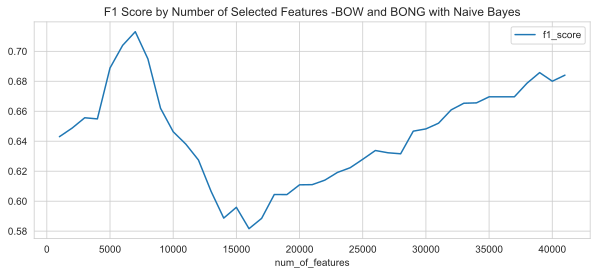

In [120]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [121]:
Opt_no_of_feat = int(sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).head(5)

6950 7050 1


,num_of_features,f1_score,accuracy
6,7000,0.7130762,0.7200000
5,6000,0.7039675,0.7120000
7,8000,0.6949037,0.7080000
4,5000,0.6888627,0.6920000
38,39000,0.6857904,0.7040000


In [122]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_bow_bong, Opt_no_of_feat, x_train_bow_bong, y_train, x_test_bow_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

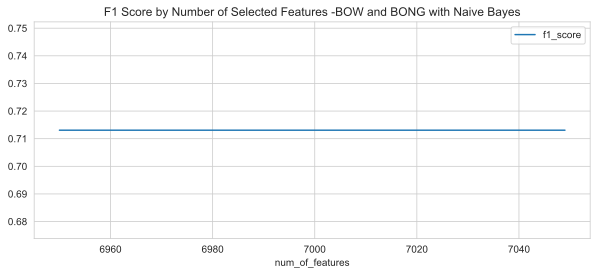

In [123]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [124]:
model_bow_bong = MultinomialNB()
results_nb_bow_bong = SelectBestModelFeatures_Chi(model_bow_bong, Opt_no_of_feat, x_train_bow_bong, y_train, x_test_bow_bong, y_test, scaler_min_max)
Save_Benchmark("BOW + Bag of NGrams Top: " + str(Opt_no_of_feat) + " Features with Naive Bayes", "BOW_BONG", results_nb_bow_bong, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW + Bag of NGrams Top: 7000 Features with Naive Bayes,BOW_BONG,0.7848327,0.7200000,0.7130762,0.7200000


## Try PCA Feature Extraction on the BOW Model 

In [125]:
from sklearn.decomposition import PCA

# Define PCA Selection Function
def SelectBestModelFeatures_PCA(model, i,  X_train_pca, y_train_pca, X_test_pca, y_test_pca):
    pca = PCA(n_components=i)
    fit = pca.fit(X_train_pca, y_train_pca)
    ftr_train = fit.transform(X_train_pca)
    ftr_test = fit.transform(X_test_pca)
    #model = GaussianNB()
    results_nb_pca = Build_Model(model, ftr_train, y_train, ftr_test, y_test)
    return results_nb_pca

In [126]:
# Loop through different no. of component values
model_nb_bow = GaussianNB()
rows = []
for i in range(5, 100, 1): # range(a, b, c) will count from a to b by intervals of c.
    results_i = SelectBestModelFeatures_PCA(model_nb_bow, i,  X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, results_i.f1_score, results_i.accuracy])
acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

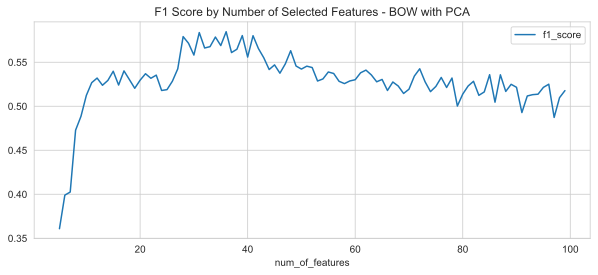

In [128]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with PCA", figsize=(10, 4))

In [129]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

36


,num_of_features,f1_score,accuracy
31,36,0.5847188,0.5960000
26,31,0.5837370,0.5920000
34,39,0.5803033,0.5920000
36,41,0.5801703,0.5920000
23,28,0.5791569,0.5880000


In [130]:
results_i = SelectBestModelFeatures_PCA(model_nb_bow, Opt_no_of_feat,  X_train_bow, y_train, X_test_bow, y_test)
Save_Benchmark("BOW With Top: " + str(Opt_no_of_feat) + "  PCA Components Seleted", "BOW_PCA", results_i, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW and Bag of N-Grams Combined Baseline,BOW_BONG,0.7848327,0.7200000,0.7130762,0.7200000
1,BOW With Top: 36 PCA Components Seleted,BOW_PCA,0.6207596,0.5920000,0.5804592,0.5920000


## Feature Engineering, Extraction and Selection Final Results

In [131]:
# Show All benchmarks
df_benchmarks_all

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.7243102,0.6960000,0.6838492,0.6960000
1,BOW Naive Bayes Optimal Features Selected: 1470,BOW,0.7656818,0.7360000,0.7336865,0.7360000
2,Bag of N-Gram Naive Bayes baseline,BONG,0.6401657,0.6000000,0.5697283,0.6000000
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 4080,BONG,0.6797066,0.6480000,0.6408318,0.6480000
4,TF-IDF Naive Bayes Baseline,TF-IDF,0.6391206,0.6080000,0.5563710,0.6080000
5,TF-IDF Naive Bayes Optimal Features Selected: 1100,TF-IDF,0.7315170,0.6280000,0.5748536,0.6280000
6,Word2Vec Naive Bayes Baseline,Word2Vec,0.6512414,0.6480000,0.6379862,0.6480000
7,Word2Vec Naive Bayes Optimal Features Selected: 89,Word2Vec,0.6792014,0.6640000,0.6595766,0.6640000
8,Word2Vec Fastext Naive Bayes Baseline,Word2Vec_FT,0.6491872,0.5960000,0.5457620,0.5960000
9,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 89,Word2Vec_FT,0.6491047,0.6080000,0.5575331,0.6080000


#### Best results were produced from the BOW Features with optimal Features selected using a Naive Bayes Multinomial Model

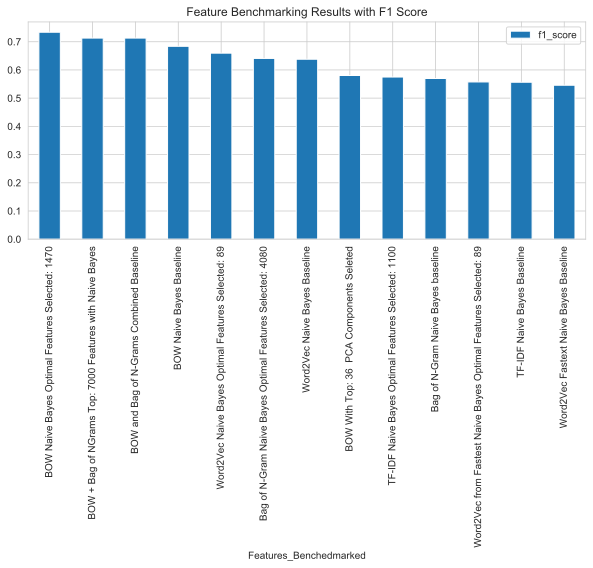

In [132]:
df_benchmarks_all.sort_values(by='f1_score', ascending=False).plot(x="Features_Benchedmarked", y="f1_score", kind='bar', title="Feature Benchmarking Results with F1 Score", figsize=(10, 4))

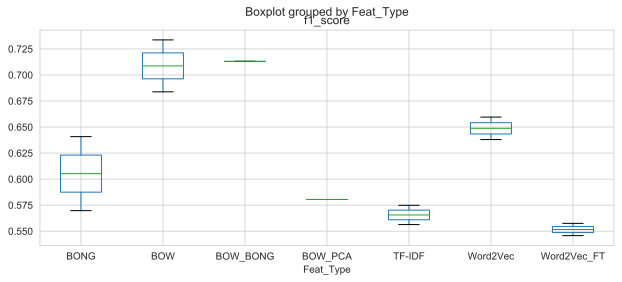

In [141]:
df_benchmarks_all.boxplot(column=['f1_score'], by='Feat_Type', figsize=(10, 4))

#### Confusion Matrix Heat Map of the Predictions fron the Best Resulting Features
#### This gives us a visual on where the model is failing

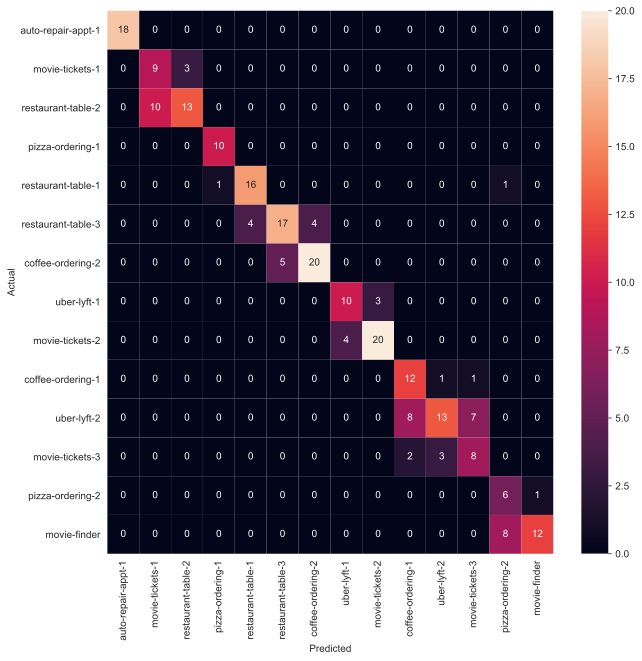

In [133]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(rm_chi_opt_bow.cm, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask

corpus_df.columns

In [185]:
# Uncomment this section to re-write data files
# c_df = corpus_df.filter(['selfdialog_norm','Instruction_id'], axis=1)
# c_df.columns = ['text', 'label_instruction_id']

# train, dev, test = np.split(c_df.sample(frac=1), [int(.6*len(c_df)), int(.8*len(c_df))])
# train.to_csv(r'.\flairdata\train.txt')
# dev.to_csv(r'.\flairdata\dev.txt')
# test.to_csv(r'.\flairdata\test.txt')

In [15]:
# this is the folder in which train, test and dev files reside
data_folder = './flairdata'

# column format indicating which columns hold the text and label(s)
column_name_map = {1: "text", 2: "label_instruction_id"}

# load corpus containing training, test and dev data and if CSV has a header, you can skip it
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter=',', 
)

2020-04-19 01:17:18,006 Reading data from flairdata
2020-04-19 01:17:18,007 Train: flairdata\train.txt
2020-04-19 01:17:18,007 Dev: flairdata\dev.txt
2020-04-19 01:17:18,008 Test: flairdata\test.txt


In [16]:
# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('glove'),

                   # comment in flair embeddings for state-of-the-art results
                   # FlairEmbeddings('news-forward'),
                   # FlairEmbeddings('news-backward'),
                   ]

2020-04-19 01:17:26,131 Computing label dictionary. Progress:
100%|██████████| 600/600 [00:01<00:00, 339.48it/s]2020-04-19 01:18:03,521 [b'pizza-ordering-1', b'restaurant-table-2', b'movie-tickets-1', b'movie-finder', b'auto-repair-appt-1', b'movie-tickets-2', b'movie-tickets-3', b'pizza-ordering-2', b'restaurant-table-3', b'coffee-ordering-1', b'uber-lyft-1', b'uber-lyft-2', b'restaurant-table-1', b'coffee-ordering-2']



In [17]:
print(corpus)

Corpus: 600 train + 200 dev + 200 test sentences


In [19]:
# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )

In [20]:
# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('resources/taggers/ag_news',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=6)

2020-04-19 01:21:19,525 ----------------------------------------------------------------------------------------------------
2020-04-19 01:21:19,526 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
    )
    (word_reprojection_map): Linear(in_features=100, out_features=256, bias=True)
    (rnn): GRU(256, 512, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Linear(in_features=512, out_features=14, bias=True)
  (loss_function): CrossEntropyLoss()
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2020-04-19 01:21:19,527 ----------------------------------------------------------------------------------------------------
2020-04-19 01:21:19,528 Corpus: "Corpus: 600 train + 200 dev + 200 test sentences"
2020-04-19 01:21:19,529 ----------------------------------------------------------------------------------------------------
2020-04-19 01:21:1

{'test_score': 0.14,
 'dev_score_history': [0.05, 0.125, 0.145, 0.155, 0.19, 0.14],
 'train_loss_history': [2.6984753106769763,
  2.6266587282481946,
  2.570343858317325,
  2.5035995182238127,
  2.4360620975494385,
  2.412053396827296],
 'dev_loss_history': [tensor(2.6548),
  tensor(2.5867),
  tensor(2.5366),
  tensor(2.5362),
  tensor(2.4764),
  tensor(2.4346)]}

In [22]:
from flair.embeddings import Sentence

# create example sentence
sentence = Sentence('France is the current world cup winner.')

# predict class and print
classifier.predict(sentence)

print(sentence.labels)

[uber-lyft-1 (0.12404996901750565)]
